In [1]:
import os
from pathlib import Path
import pickle

os.environ['ARTEFACT_DIR'] = '/home/hylke/digits'


import jax
from jax.tree_util import tree_map
from matplotlib import pyplot as plt
from mubelnet.random import PRNGSequence
from mubelnet.utils import perplexity
import numpy as np

from dataset import load_digits


# Training hyperparameters
RANDOM_SEED = 42
key_seq = PRNGSequence(jax.random.PRNGKey(RANDOM_SEED))


# Model hyperparameters.
MODEL = "multinomial_dirichlet_believe"
n_topics = 10
HIDDEN_LAYER_SIZES = (n_topics, n_topics, n_topics)
GAMMA_0 = 1.0
ETA = 0.05
_bottom_layer_name = (
    f"{MODEL}/~/multinomial_layer"
    if MODEL == "multinomial_dirichlet_believe"
    else f"{MODEL}/~/poisson_layer"
)

X_train, X_test = load_digits()
n_features = X_train.shape[1]

def probability(params, state):
    bottom_params = params.get(_bottom_layer_name, {})
    bottom_state = state[_bottom_layer_name]
    phi = bottom_params.get("phi", bottom_state.get("phi"))
    theta = bottom_state["copy[theta(1)]"]
    probs = theta @ phi
    probs /= probs.sum(axis=-1, keepdims=True)
    return probs


def evaluate(params, states, X, axis=[0, 1]):
    """Compute perplexity over chains and samples by default (axis=[0, 1])."""
    probs = probability(params, states).mean(axis)
    return perplexity(X, probs)

2023-11-22 16:11:35.410242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_trace(pkl_path: Path, thin: int = 1):
    with open(pkl_path, 'rb') as fi:
        trace_10_10_10 = pickle.load(fi)
    t_10_10_10 = tree_map(lambda x: x[:, ::thin], trace_10_10_10)
    del trace_10_10_10
    trace_10_10_10 = t_10_10_10
    return trace_10_10_10

In [3]:
trace = load_trace(Path('/home/hylke/digits/multinomial_belief/10-10-10/samples/sample_1000.pkl'), thin=10)

In [4]:
r = np.mean(trace['multinomial_dirichlet_believe/~/cap_layer']['r'], axis=[1])
phi_1st_layer = np.mean(trace['multinomial_dirichlet_believe/~/multinomial_layer']['phi'], axis=[1])
phi_2nd_layer = np.mean(trace['multinomial_dirichlet_believe/~/dirichlet_layer']['phi'], axis=[1])
phi_3rd_layer = np.mean(trace['multinomial_dirichlet_believe/~/dirichlet_layer_1']['phi'], axis=[1])

In [5]:
p_31 = (phi_3rd_layer @ phi_2nd_layer @ phi_1st_layer).squeeze()
p_21 = (phi_2nd_layer @ phi_1st_layer).squeeze()
p_1 = phi_1st_layer

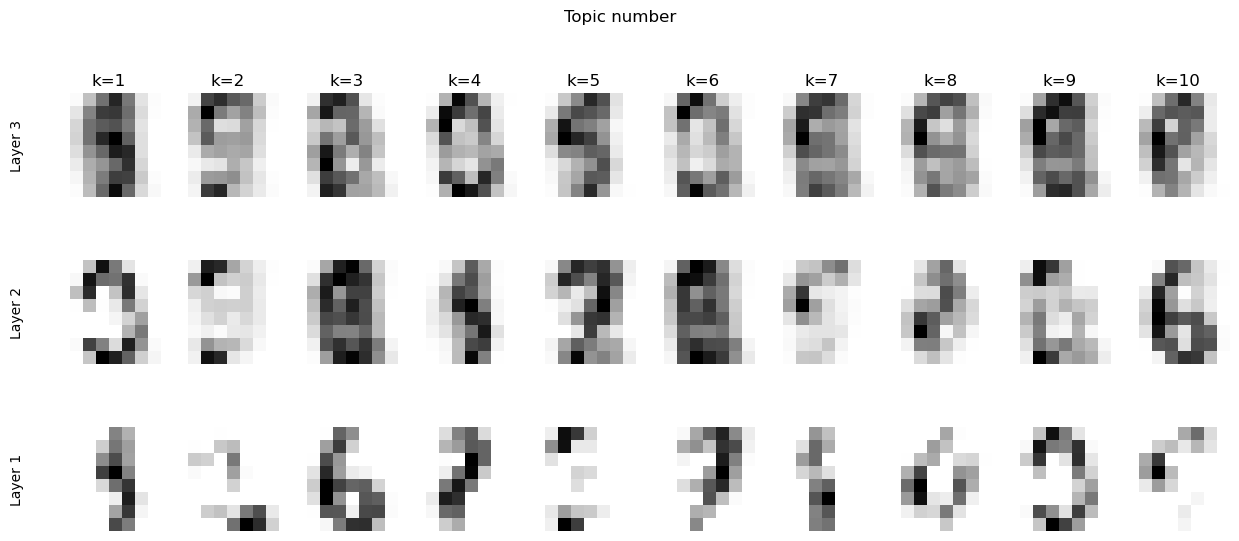

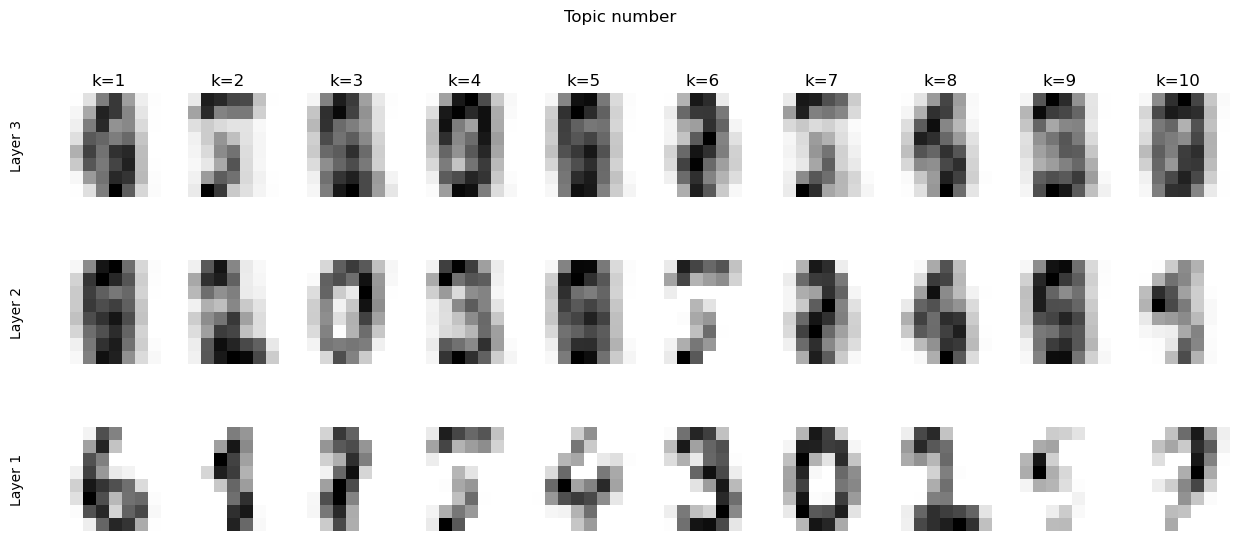

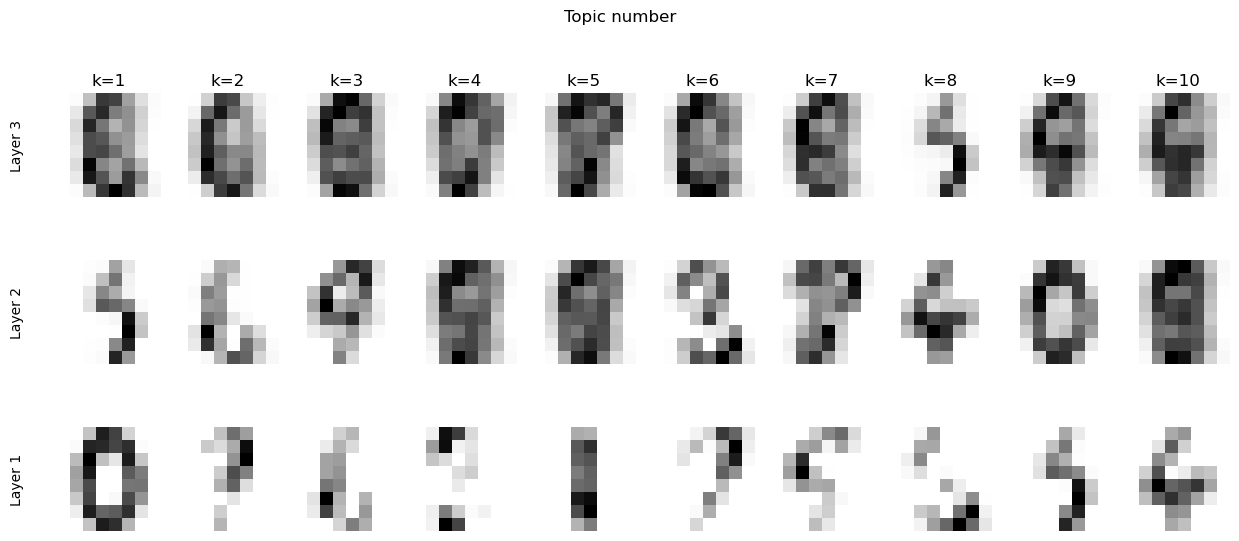

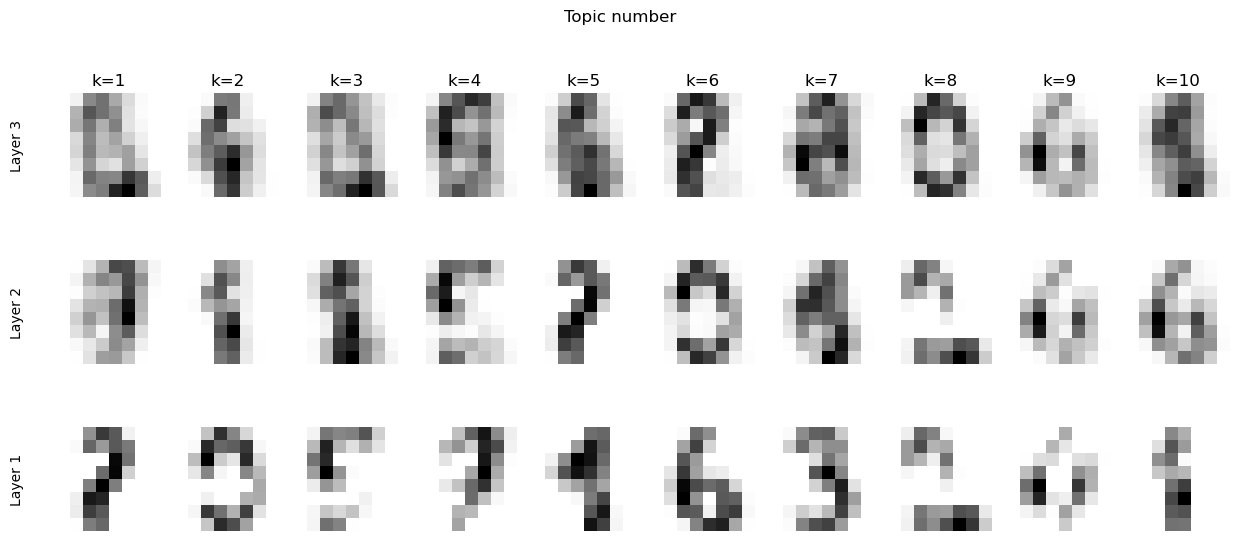

In [6]:
n_chains = 4
for i in range(n_chains):  # For each Markov chain.
    # f = plt.figure(figsize=(12.5, 6))
    f, axes = plt.subplots(nrows=3, ncols=10, figsize=(12.5, 6))
    # plt.suptitle(f'Chain {i+1}')
    projections = [p_31, p_21, p_1]
    # Plot the weights of all 10 hidden states.
    for layer_nr, (ax_cols, feature_projec) in enumerate(zip(axes, projections)):
        ax_cols[0].set_ylabel(f"Layer {3 - layer_nr}", labelpad=20)
        for k, (ax, phi) in enumerate(zip(ax_cols, feature_projec[i])):
            image = phi.reshape(8, 8)
            ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
            axes[0, k].set_title(f"k={k+1}")
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)
    plt.suptitle('Topic number')
    plt.tight_layout()
    f.savefig(f'figs/digits_chain_{i+1}.pdf', bbox_inches='tight')
    f.savefig(f'figs/digits_chain_{i+1}.eps', bbox_inches='tight')
    f.savefig(f'figs/digits_chain_{i+1}.svg', bbox_inches='tight')